In [2]:
import pandas as pd

enriched_path = "/workspaces/maxsold/data/raw_data/item_enriched_details/item_enriched_details_20251201.parquet"
items_path = "/workspaces/maxsold/data/raw_data/items_details/items_details_20251201.parquet"

# Read enriched data and only the needed columns from items details
df_enriched = pd.read_parquet(enriched_path)
df_items = pd.read_parquet(items_path, columns=["id", "current_bid"])

# Ensure merge keys have the same dtype (convert both to string)
df_enriched["item_id"] = df_enriched["item_id"].astype(str)
df_items["id"] = df_items["id"].astype(str)

# Merge: keep all columns from enriched and only current_bid from items details
merged = df_enriched.merge(df_items[["id", "current_bid"]], left_on="item_id", right_on="id", how="left")
if "id" in merged.columns:
    merged = merged.drop(columns=["id"])

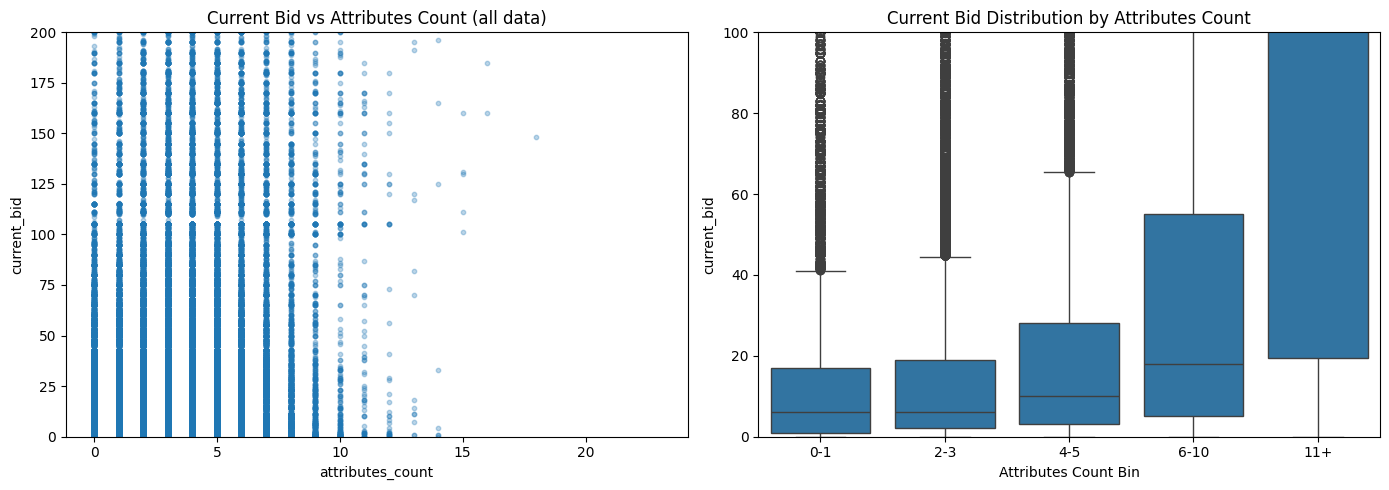

Correlation between attributes_count and current_bid: 0.1352

Summary statistics by attributes_count bins:

0-1 attributes:
  Count: 24529
  Mean bid: $18.56
  Median bid: $6.00
  Std: $71.43

2-3 attributes:
  Count: 97299
  Mean bid: $20.60
  Median bid: $6.00
  Std: $88.66

4-5 attributes:
  Count: 65174
  Mean bid: $31.50
  Median bid: $10.00
  Std: $99.94

6-10 attributes:
  Count: 18434
  Mean bid: $67.97
  Median bid: $18.00
  Std: $239.50

11+ attributes:
  Count: 228
  Mean bid: $330.25
  Median bid: $130.25
  Std: $800.87


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze relationship between current_bid and attributes_count
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with alpha for density visualization
axes[0].scatter(merged["attributes_count"], merged["current_bid"], alpha=0.3, s=10)
axes[0].set_xlabel("attributes_count")
axes[0].set_ylabel("current_bid")
axes[0].set_title("Current Bid vs Attributes Count (all data)")
axes[0].set_ylim(0, 200)

# Box plot by attributes_count bins
merged_with_bid = merged[merged["current_bid"] >= 0].copy()
merged_with_bid["attr_bin"] = pd.cut(merged_with_bid["attributes_count"], bins=[0, 1, 3, 5, 10, 20], labels=["0-1", "2-3", "4-5", "6-10", "11+"])
sns.boxplot(data=merged_with_bid, x="attr_bin", y="current_bid", ax=axes[1])
axes[1].set_xlabel("Attributes Count Bin")
axes[1].set_ylabel("current_bid")
axes[1].set_title("Current Bid Distribution by Attributes Count")
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = merged["attributes_count"].corr(merged["current_bid"])
print(f"Correlation between attributes_count and current_bid: {correlation:.4f}")

# Summary statistics by attributes_count bins
print("\nSummary statistics by attributes_count bins:")
for name, group in merged_with_bid.groupby("attr_bin", observed=True):
    print(f"\n{name} attributes:")
    print(f"  Count: {len(group)}")
    print(f"  Mean bid: ${group['current_bid'].mean():.2f}")
    print(f"  Median bid: ${group['current_bid'].median():.2f}")
    print(f"  Std: ${group['current_bid'].std():.2f}")

Top 15 most common attribute name-value pairs:
     attr_name attr_value  count
         color      black   4953
      material       wood   4739
      material    ceramic   4348
      material      glass   3772
      material  porcelain   3767
      material      metal   3122
      material    plastic   2729
         color      white   2580
        signed        yes   2366
frame_material       wood   1812
        framed        yes   1363
         style    vintage   1342
        format  hardcover   1332
      material    leather   1289
         metal     silver   1235


Attribute: color = black
  Count: 4953 items
  Mean bid: $23.83
  Median bid: $6.01
  Mean (non-zero): $26.76
  Median (non-zero): $9.00
  Std: $88.26
  Min: $0.00, Max: $5000.00

Attribute: material = wood
  Count: 4739 items
  Mean bid: $22.22
  Median bid: $6.00
  Mean (non-zero): $24.88
  Median (non-zero): $8.02
  Std: $59.37
  Min: $0.00, Max: $1910.00

Attribute: material = ceramic
  Count: 4348 items
  Mean bid:

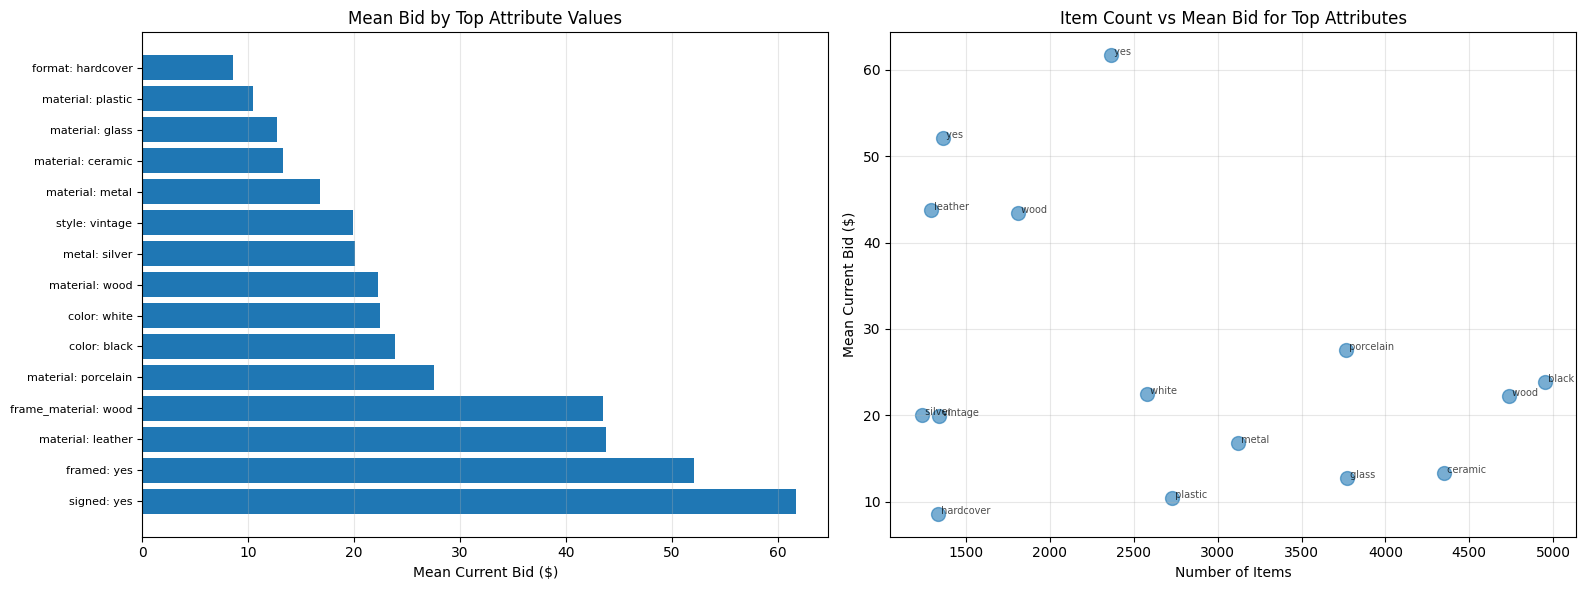

In [9]:
import numpy as np

# Analyze most common attribute values and their relationship with current_bid

# Parse all attributes and collect name-value pairs
attribute_pairs = []
for idx, row in merged.iterrows():
    if pd.isna(row["attributes"]):
        continue
    parsed = row["attributes"]
    if isinstance(parsed, str):
        try:
            parsed = json.loads(parsed)
        except Exception:
            try:
                parsed = ast.literal_eval(parsed)
            except Exception:
                continue
    if not isinstance(parsed, list):
        continue
    for entry in parsed:
        if not isinstance(entry, dict):
            continue
        name = (entry.get("name") or entry.get("title") or "").lower().strip()
        value = entry.get("value") or entry.get("values") or entry.get("text")
        if name and value:
            # Convert value to string and clean it
            value_str = str(value).lower().strip()
            if value_str and value_str != "none" and len(value_str) < 100:  # Skip very long values
                attribute_pairs.append({
                    "item_id": row["item_id"],
                    "attr_name": name,
                    "attr_value": value_str,
                    "current_bid": row["current_bid"]
                })

df_attrs = pd.DataFrame(attribute_pairs)

# Find top 15 most common attribute name-value pairs
top_pairs = df_attrs.groupby(["attr_name", "attr_value"]).size().nlargest(15).reset_index(name="count")

print("Top 15 most common attribute name-value pairs:")
print(top_pairs.to_string(index=False))
print("\n" + "="*80 + "\n")

# For each top pair, show bid statistics
for _, row in top_pairs.iterrows():
    attr_name = row["attr_name"]
    attr_value = row["attr_value"]
    count = row["count"]
    
    # Get bids for items with this attribute
    mask = (df_attrs["attr_name"] == attr_name) & (df_attrs["attr_value"] == attr_value)
    bids = df_attrs[mask]["current_bid"]
    bids_nonzero = bids[bids > 0]
    
    print(f"Attribute: {attr_name} = {attr_value}")
    print(f"  Count: {count} items")
    print(f"  Mean bid: ${bids.mean():.2f}")
    print(f"  Median bid: ${bids.median():.2f}")
    if len(bids_nonzero) > 0:
        print(f"  Mean (non-zero): ${bids_nonzero.mean():.2f}")
        print(f"  Median (non-zero): ${bids_nonzero.median():.2f}")
    print(f"  Std: ${bids.std():.2f}")
    print(f"  Min: ${bids.min():.2f}, Max: ${bids.max():.2f}")
    print()

# Visualize top attribute values by average bid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create data for visualization
vis_data = []
for _, row in top_pairs.iterrows():
    mask = (df_attrs["attr_name"] == row["attr_name"]) & (df_attrs["attr_value"] == row["attr_value"])
    bids = df_attrs[mask]["current_bid"]
    bids_nonzero = bids[bids > 0]
    
    vis_data.append({
        "label": f"{row['attr_name']}: {row['attr_value'][:30]}",
        "mean_bid": bids.mean(),
        "median_bid": bids.median(),
        "count": row["count"],
        "mean_nonzero": bids_nonzero.mean() if len(bids_nonzero) > 0 else 0
    })

vis_df = pd.DataFrame(vis_data).sort_values("mean_bid", ascending=False)

# Bar plot of mean bids
axes[0].barh(range(len(vis_df)), vis_df["mean_bid"])
axes[0].set_yticks(range(len(vis_df)))
axes[0].set_yticklabels(vis_df["label"], fontsize=8)
axes[0].set_xlabel("Mean Current Bid ($)")
axes[0].set_title("Mean Bid by Top Attribute Values")
axes[0].grid(axis='x', alpha=0.3)

# Scatter: count vs mean bid
axes[1].scatter(vis_df["count"], vis_df["mean_bid"], s=100, alpha=0.6)
axes[1].set_xlabel("Number of Items")
axes[1].set_ylabel("Mean Current Bid ($)")
axes[1].set_title("Item Count vs Mean Bid for Top Attributes")
axes[1].grid(alpha=0.3)

# Add labels to points
for _, row in vis_df.iterrows():
    axes[1].annotate(row["label"].split(":")[1][:15], 
                     (row["count"], row["mean_bid"]), 
                     fontsize=7, alpha=0.7)

plt.tight_layout()
plt.show()

Top 15 most common categories:
category
collectibles    27389
home decor      19871
furniture       17013
art             12936
decor           11399
kitchenware     10709
books            9006
jewellery        8973
glassware        8526
jewelry          7860
lighting         6802
electronics      6568
toys             5756
clothing         5679
tools            5207


Category: collectibles
  Count: 27389 items
  Mean bid: $19.78
  Median bid: $7.00
  Mean (non-zero): $21.21
  Median (non-zero): $8.00
  Std: $62.27
  Min: $0.00, Max: $3569.00

Category: home decor
  Count: 19871 items
  Mean bid: $23.41
  Median bid: $6.00
  Mean (non-zero): $25.66
  Median (non-zero): $8.00
  Std: $77.17
  Min: $0.00, Max: $5150.00

Category: furniture
  Count: 17013 items
  Mean bid: $52.36
  Median bid: $11.00
  Mean (non-zero): $59.99
  Median (non-zero): $17.00
  Std: $213.35
  Min: $0.00, Max: $13350.00

Category: art
  Count: 12936 items
  Mean bid: $42.57
  Median bid: $11.00
  Mean (non-zero)

/tmp/ipykernel_2503/2034748962.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right', fontsize=9)


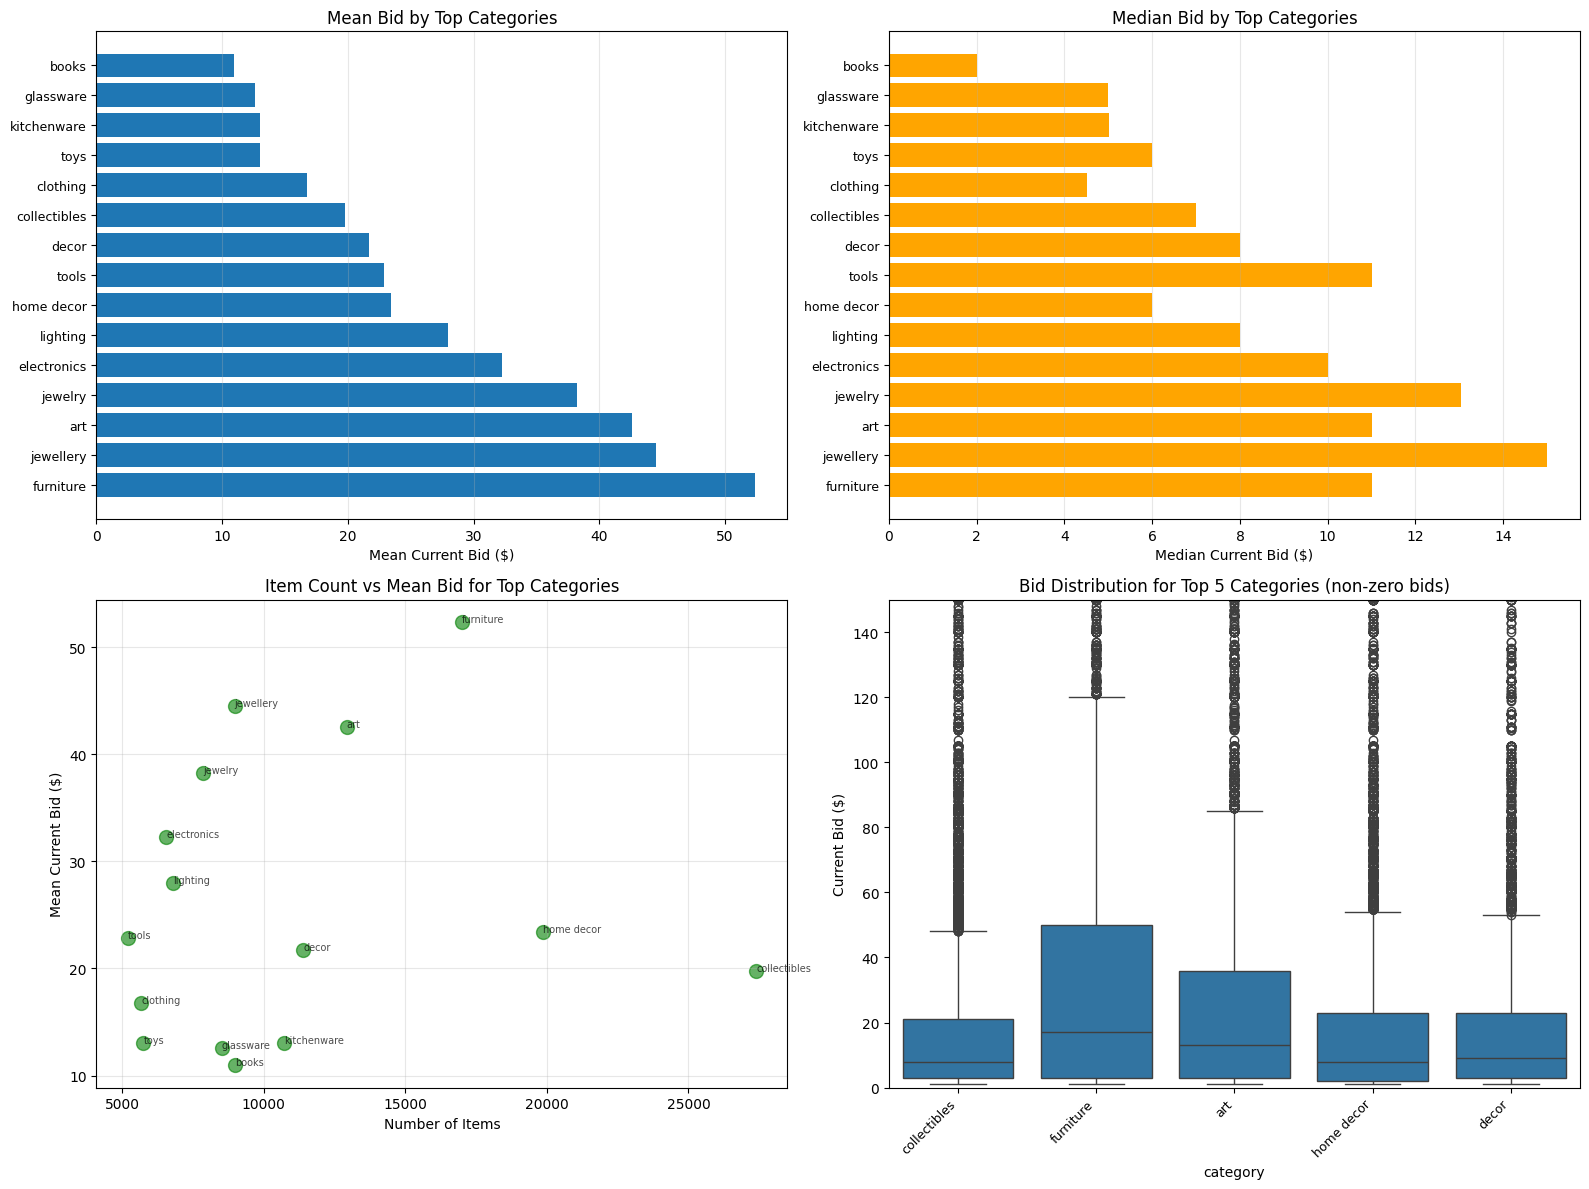

In [8]:
# Analyze most common categories vs current_bid

# Parse categories and collect category-bid pairs
category_pairs = []
for idx, row in merged.iterrows():
    if pd.isna(row["categories"]):
        continue
    parsed = row["categories"]
    if isinstance(parsed, str):
        try:
            parsed = json.loads(parsed)
        except Exception:
            try:
                parsed = ast.literal_eval(parsed)
            except Exception:
                continue
    if not isinstance(parsed, list):
        continue
    for cat in parsed:
        cat_clean = str(cat).lower().strip()
        if cat_clean and len(cat_clean) < 100:
            category_pairs.append({
                "item_id": row["item_id"],
                "category": cat_clean,
                "current_bid": row["current_bid"]
            })

df_cats = pd.DataFrame(category_pairs)

# Find top 15 most common categories
top_categories = df_cats["category"].value_counts().nlargest(15)

print("Top 15 most common categories:")
print(top_categories.to_string())
print("\n" + "="*80 + "\n")

# For each top category, show bid statistics
cat_stats = []
for cat in top_categories.index:
    bids = df_cats[df_cats["category"] == cat]["current_bid"]
    bids_nonzero = bids[bids > 0]
    
    cat_stats.append({
        "category": cat,
        "count": len(bids),
        "mean_bid": bids.mean(),
        "median_bid": bids.median(),
        "mean_nonzero": bids_nonzero.mean() if len(bids_nonzero) > 0 else 0,
        "median_nonzero": bids_nonzero.median() if len(bids_nonzero) > 0 else 0,
        "std": bids.std(),
        "min": bids.min(),
        "max": bids.max()
    })
    
    print(f"Category: {cat}")
    print(f"  Count: {len(bids)} items")
    print(f"  Mean bid: ${bids.mean():.2f}")
    print(f"  Median bid: ${bids.median():.2f}")
    if len(bids_nonzero) > 0:
        print(f"  Mean (non-zero): ${bids_nonzero.mean():.2f}")
        print(f"  Median (non-zero): ${bids_nonzero.median():.2f}")
    print(f"  Std: ${bids.std():.2f}")
    print(f"  Min: ${bids.min():.2f}, Max: ${bids.max():.2f}")
    print()

# Visualize categories by average bid
cat_stats_df = pd.DataFrame(cat_stats).sort_values("mean_bid", ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Bar plot of mean bids
axes[0, 0].barh(range(len(cat_stats_df)), cat_stats_df["mean_bid"])
axes[0, 0].set_yticks(range(len(cat_stats_df)))
axes[0, 0].set_yticklabels(cat_stats_df["category"], fontsize=9)
axes[0, 0].set_xlabel("Mean Current Bid ($)")
axes[0, 0].set_title("Mean Bid by Top Categories")
axes[0, 0].grid(axis='x', alpha=0.3)

# Bar plot of median bids
axes[0, 1].barh(range(len(cat_stats_df)), cat_stats_df["median_bid"], color='orange')
axes[0, 1].set_yticks(range(len(cat_stats_df)))
axes[0, 1].set_yticklabels(cat_stats_df["category"], fontsize=9)
axes[0, 1].set_xlabel("Median Current Bid ($)")
axes[0, 1].set_title("Median Bid by Top Categories")
axes[0, 1].grid(axis='x', alpha=0.3)

# Scatter: count vs mean bid
axes[1, 0].scatter(cat_stats_df["count"], cat_stats_df["mean_bid"], s=100, alpha=0.6, c='green')
axes[1, 0].set_xlabel("Number of Items")
axes[1, 0].set_ylabel("Mean Current Bid ($)")
axes[1, 0].set_title("Item Count vs Mean Bid for Top Categories")
axes[1, 0].grid(alpha=0.3)
for _, row in cat_stats_df.iterrows():
    axes[1, 0].annotate(row["category"][:20], 
                        (row["count"], row["mean_bid"]), 
                        fontsize=7, alpha=0.7)

# Box plot for selected top categories
top_5_cats = top_categories.head(5).index.tolist()
cat_plot_data = df_cats[df_cats["category"].isin(top_5_cats) & (df_cats["current_bid"] > 0)].copy()
sns.boxplot(data=cat_plot_data, x="category", y="current_bid", ax=axes[1, 1])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right', fontsize=9)
axes[1, 1].set_ylabel("Current Bid ($)")
axes[1, 1].set_title("Bid Distribution for Top 5 Categories (non-zero bids)")
axes[1, 1].set_ylim(0, 150)

plt.tight_layout()
plt.show()

items_count statistics:
count    229124.0
mean     2.837058
std      3.055796
min           0.0
25%           1.0
50%           1.0
75%           4.0
max          67.0
Name: items_count, dtype: Float64

Current bid statistics:
count    229124.000000
mean         26.836169
std         111.311859
min           0.000000
25%           2.000000
50%           7.000000
75%          23.000000
max       14000.000000
Name: current_bid, dtype: float64

Valid data points: 229,124


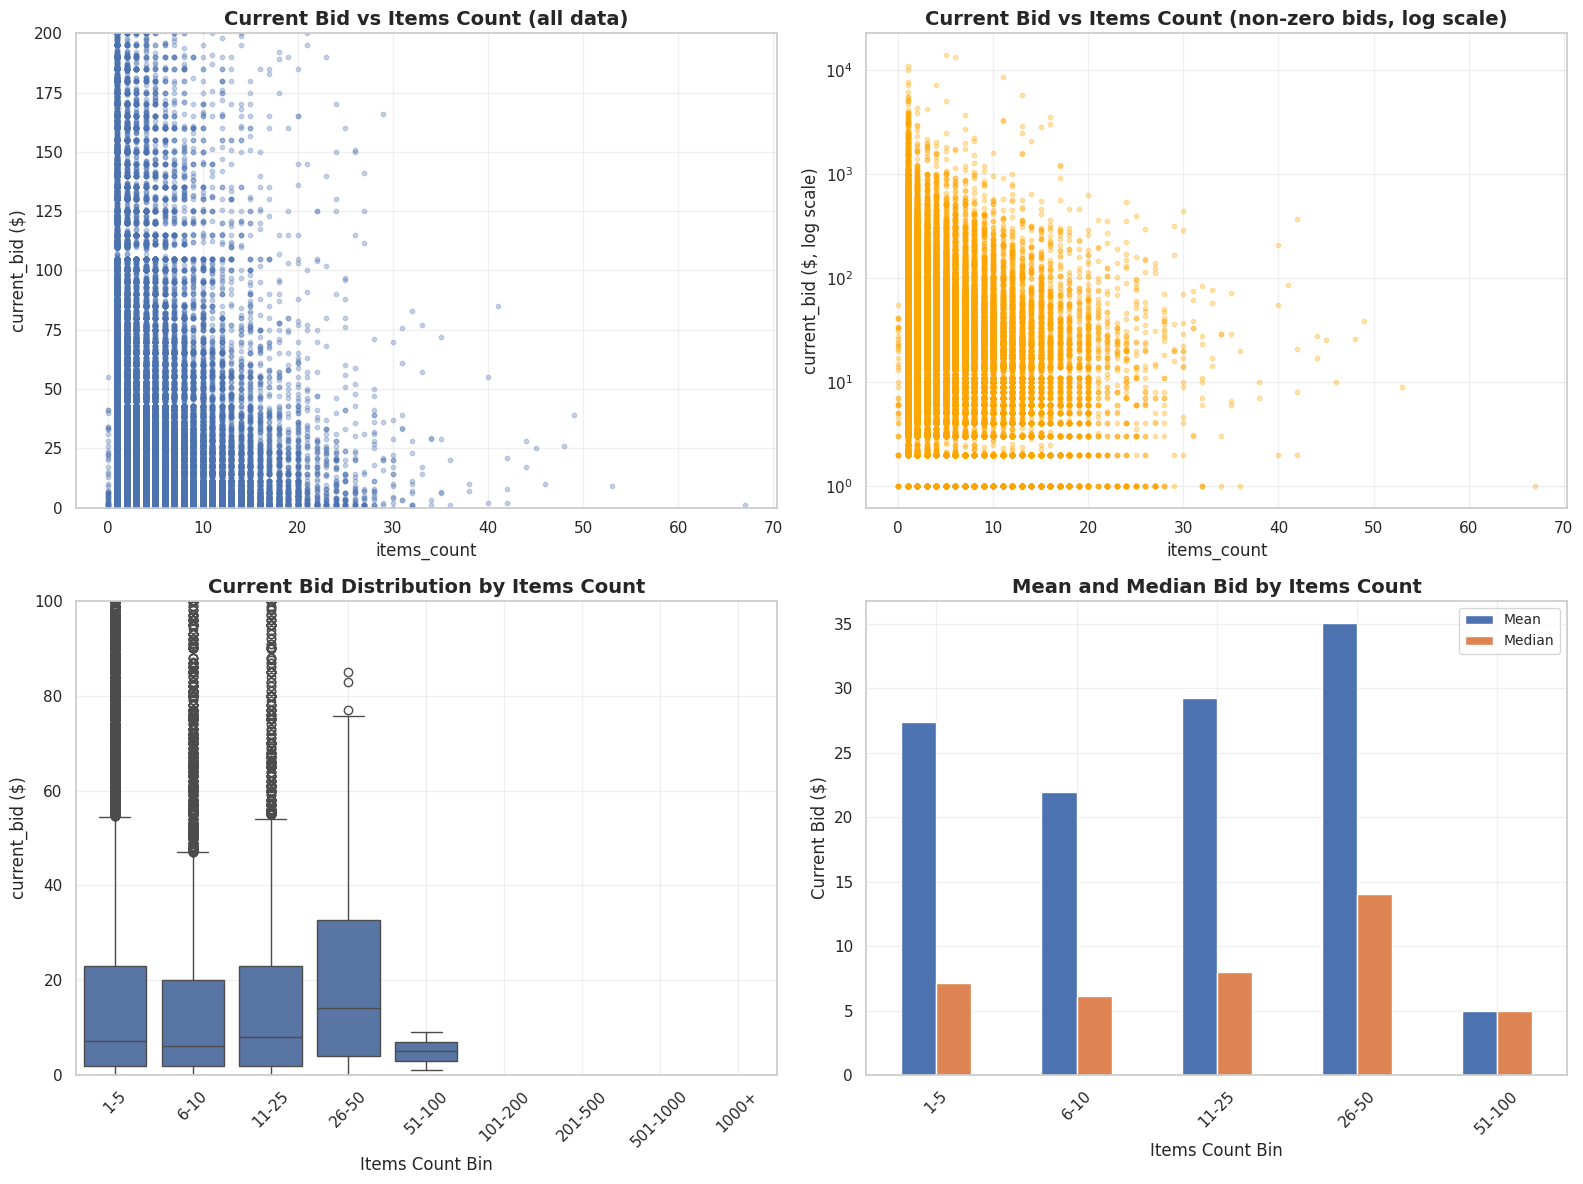


Correlation between items_count and current_bid: -0.0155

Summary statistics by items_count bins:

1-5 items:
  Count: 196,668
  Mean bid: $27.38
  Median bid: $7.16
  Std: $109.00
  Min: $0.00
  Max: $14000.00
  Non-zero bids: 180,108 (91.6%)
  Mean (non-zero): $29.89
  Median (non-zero): $9.00

6-10 items:
  Count: 25,207
  Mean bid: $21.93
  Median bid: $6.15
  Std: $108.66
  Min: $0.00
  Max: $13350.00
  Non-zero bids: 23,352 (92.6%)
  Mean (non-zero): $23.67
  Median (non-zero): $8.00

11-25 items:
  Count: 7,033
  Mean bid: $29.26
  Median bid: $8.00
  Std: $169.95
  Min: $0.00
  Max: $8600.00
  Non-zero bids: 6,634 (94.3%)
  Mean (non-zero): $31.01
  Median (non-zero): $9.00

26-50 items:
  Count: 158
  Mean bid: $35.03
  Median bid: $14.05
  Std: $66.40
  Min: $0.00
  Max: $438.00
  Non-zero bids: 154 (97.5%)
  Mean (non-zero): $35.94
  Median (non-zero): $14.18

51-100 items:
  Count: 2
  Mean bid: $5.00
  Median bid: $5.00
  Std: $5.66
  Min: $1.00
  Max: $9.00
  Non-zero bi

In [ ]:
# Analyze relationship between items_count and current_bid

# Check if items_count exists
if 'items_count' not in merged.columns:
    print("Column 'items_count' not found in merged dataframe.")
    print(f"Available columns: {merged.columns.tolist()}")
else:
    print(f"items_count statistics:")
    print(merged['items_count'].describe())
    print(f"\nCurrent bid statistics:")
    print(merged['current_bid'].describe())
    
    # Filter to valid data
    valid_data = merged[(merged['items_count'].notna()) & (merged['current_bid'].notna())].copy()
    print(f"\nValid data points: {len(valid_data):,}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Scatter plot: items_count vs current_bid
    axes[0, 0].scatter(valid_data['items_count'], valid_data['current_bid'], alpha=0.3, s=10)
    axes[0, 0].set_xlabel('items_count', fontsize=12)
    axes[0, 0].set_ylabel('current_bid ($)', fontsize=12)
    axes[0, 0].set_title('Current Bid vs Items Count (all data)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylim(0, 200)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Scatter plot (log scale for better visibility)
    non_zero = valid_data[valid_data['current_bid'] > 0].copy()
    axes[0, 1].scatter(non_zero['items_count'], non_zero['current_bid'], alpha=0.3, s=10, color='orange')
    axes[0, 1].set_xlabel('items_count', fontsize=12)
    axes[0, 1].set_ylabel('current_bid ($, log scale)', fontsize=12)
    axes[0, 1].set_title('Current Bid vs Items Count (non-zero bids, log scale)', fontsize=14, fontweight='bold')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Box plot by items_count bins
    valid_data['items_bin'] = pd.cut(valid_data['items_count'], 
                                      bins=[0, 5, 10, 25, 50, 100, 200, 500, 1000, 5000], 
                                      labels=['1-5', '6-10', '11-25', '26-50', '51-100', '101-200', '201-500', '501-1000', '1000+'])
    sns.boxplot(data=valid_data, x='items_bin', y='current_bid', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Items Count Bin', fontsize=12)
    axes[1, 0].set_ylabel('current_bid ($)', fontsize=12)
    axes[1, 0].set_title('Current Bid Distribution by Items Count', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylim(0, 100)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Mean bid by items_count bin
    bin_stats = valid_data.groupby('items_bin', observed=True)['current_bid'].agg(['mean', 'median', 'count'])
    bin_stats.plot(kind='bar', y=['mean', 'median'], ax=axes[1, 1])
    axes[1, 1].set_xlabel('Items Count Bin', fontsize=12)
    axes[1, 1].set_ylabel('Current Bid ($)', fontsize=12)
    axes[1, 1].set_title('Mean and Median Bid by Items Count', fontsize=14, fontweight='bold')
    axes[1, 1].legend(['Mean', 'Median'], fontsize=10)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    correlation = valid_data['items_count'].corr(valid_data['current_bid'])
    print(f"\n{'='*80}")
    print(f"Correlation between items_count and current_bid: {correlation:.4f}")
    print(f"{'='*80}")
    
    # Summary statistics by items_count bins
    print("\nSummary statistics by items_count bins:")
    print("="*80)
    for name, group in valid_data.groupby('items_bin', observed=True):
        print(f"\n{name} items:")
        print(f"  Count: {len(group):,}")
        print(f"  Mean bid: ${group['current_bid'].mean():.2f}")
        print(f"  Median bid: ${group['current_bid'].median():.2f}")
        print(f"  Std: ${group['current_bid'].std():.2f}")
        print(f"  Min: ${group['current_bid'].min():.2f}")
        print(f"  Max: ${group['current_bid'].max():.2f}")
        
        # Non-zero statistics
        non_zero_group = group[group['current_bid'] > 0]
        if len(non_zero_group) > 0:
            print(f"  Non-zero bids: {len(non_zero_group):,} ({100*len(non_zero_group)/len(group):.1f}%)")
            print(f"  Mean (non-zero): ${non_zero_group['current_bid'].mean():.2f}")
            print(f"  Median (non-zero): ${non_zero_group['current_bid'].median():.2f}")
    
    # Look at items with high items_count
    print("\n" + "="*80)
    print("Items with highest items_count:")
    print("="*80)
    top_items = valid_data.nlargest(10, 'items_count')[['item_id', 'items_count', 'current_bid']]
    for idx, row in top_items.iterrows():
        print(f"Item {row['item_id']}: {row['items_count']:.0f} items, current bid: ${row['current_bid']:.2f}")

Extracting materials from attributes...

Material coverage:
  Total items: 229,124
  Items with material: 84,339 (36.8%)
  Unique materials: 21016

Top 25 materials:
  wood: 4,709
  ceramic: 4,259
  glass: 3,701
  porcelain: 3,623
  metal: 3,089
  plastic: 2,682
  leather: 1,258
  brass: 1,157
  silver: 1,058
  bone_china: 810
  wool: 786
  sterling_silver: 777
  sterling silver: 672
  solid wood: 665
  stoneware: 646
  stainless_steel: 609
  crystal: 595
  steel: 577
  bone china: 553
  aluminum: 430
  stainless steel: 417
  resin: 357
  bronze: 356
  silver-tone metal: 346
  paper: 346

BID STATISTICS BY MATERIAL

wood:
  Count: 4,709 items
  Mean bid: $22.08
  Median bid: $6.00
  Std: $59.24
  Range: $0.00 - $1910.00
  Zero bids: 503 (10.7%)
  Mean (non-zero): $24.72
  Median (non-zero): $8.00

ceramic:
  Count: 4,259 items
  Mean bid: $13.21
  Median bid: $5.01
  Std: $36.70
  Range: $0.00 - $1510.00
  Zero bids: 408 (9.6%)
  Mean (non-zero): $14.60
  Median (non-zero): $6.00

glas

/tmp/ipykernel_2503/2725559159.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=9)


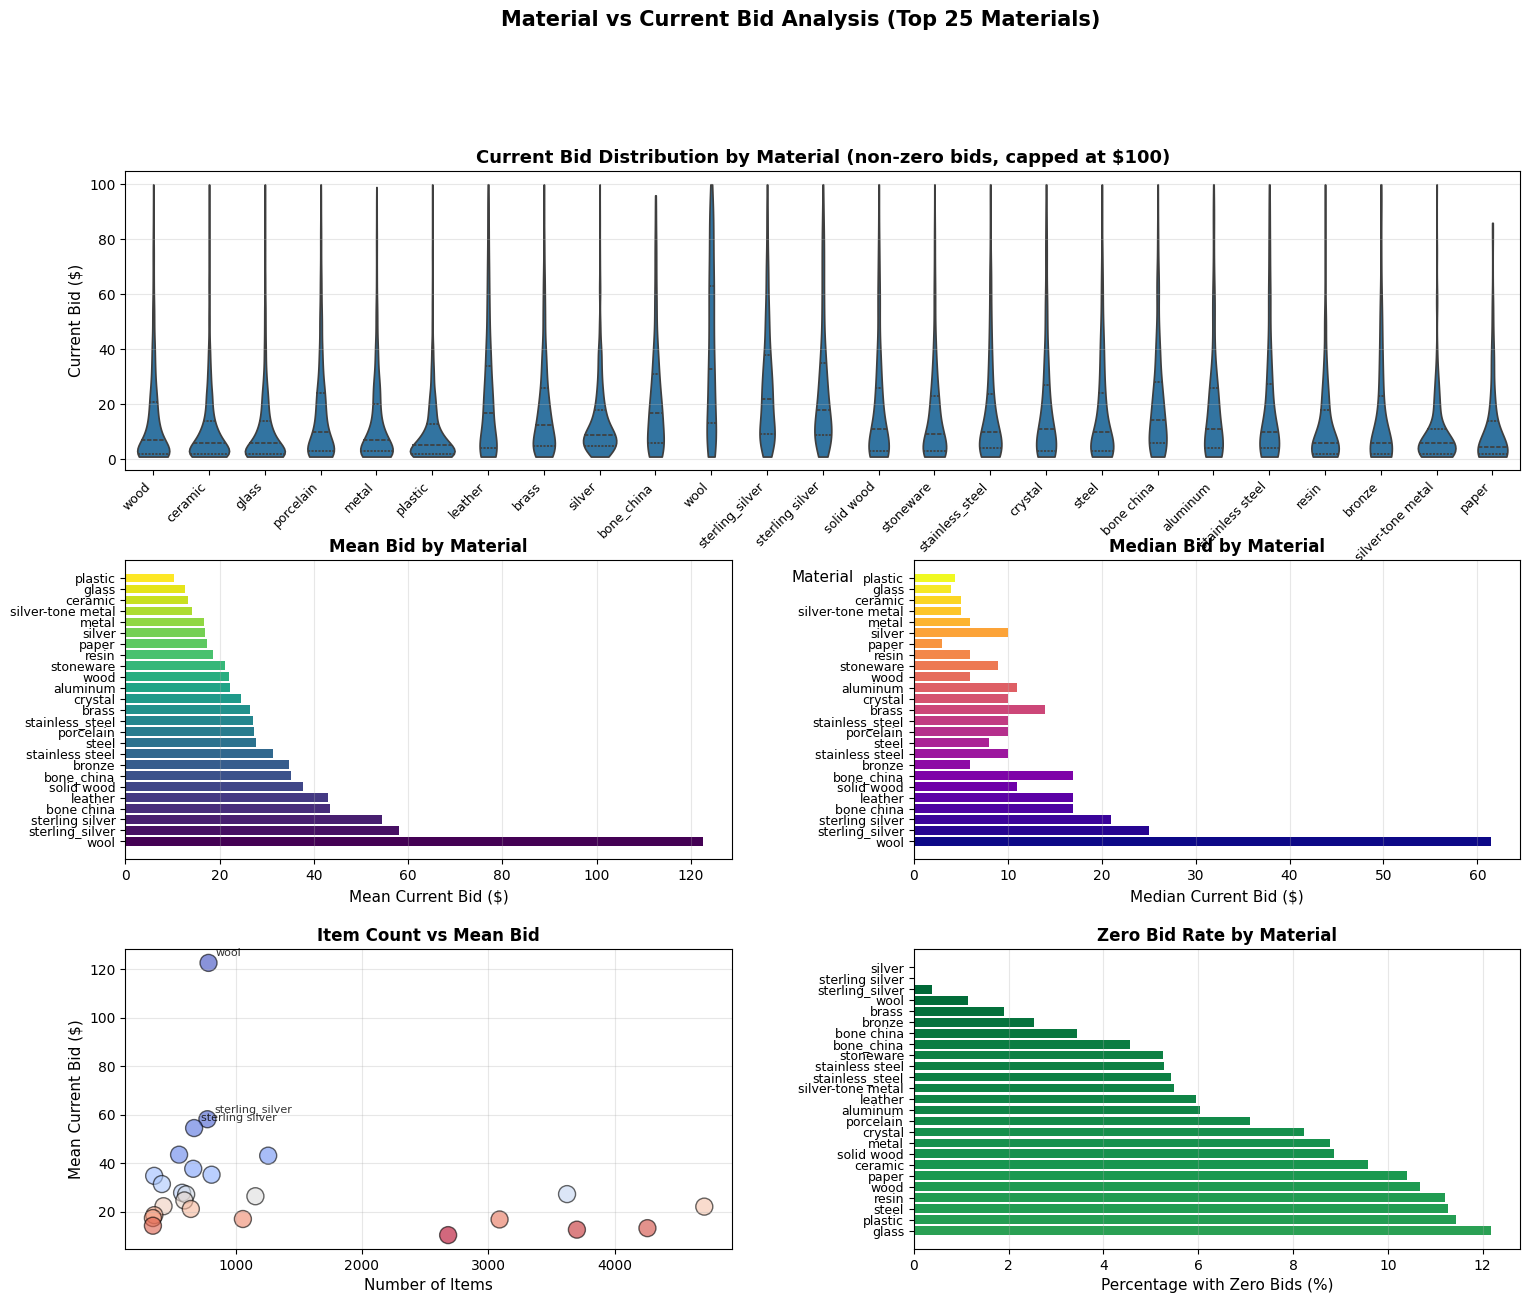


CORRELATION ANALYSIS

Correlation with current_bid (binary indicator):
  wool: 0.0505
  sterling_silver: 0.0164
  sterling silver: 0.0135
  leather: 0.0109
  bone china: 0.0074
  solid wood: 0.0053
  bone_china: 0.0045
  bronze: 0.0028
  stainless steel: 0.0017
  porcelain: 0.0005
  steel: 0.0004
  stainless_steel: 0.0001
  brass: -0.0003
  crystal: -0.0010
  aluminum: -0.0018
  stoneware: -0.0027
  resin: -0.0029
  paper: -0.0033
  silver-tone metal: -0.0044
  silver: -0.0060
  wood: -0.0062
  metal: -0.0106
  plastic: -0.0161
  glass: -0.0164
  ceramic: -0.0169


In [7]:
import json, ast
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract material from attributes column
def extract_material(attrs):
    """Extract material value from attributes JSON/list"""
    if pd.isna(attrs):
        return None
    
    # Parse if string
    parsed = attrs
    if isinstance(attrs, str):
        try:
            parsed = json.loads(attrs)
        except Exception:
            try:
                parsed = ast.literal_eval(attrs)
            except Exception:
                return None
    
    if not isinstance(parsed, list):
        return None
    
    # Look for material attribute
    for entry in parsed:
        if not isinstance(entry, dict):
            continue
        name = (entry.get("name") or entry.get("title") or "").lower()
        if name == "material":
            value = entry.get("value") or entry.get("values") or entry.get("text")
            if value:
                # Handle list values
                if isinstance(value, list):
                    return ", ".join(str(v) for v in value)
                return str(value)
    return None

# Extract materials
print("Extracting materials from attributes...")
merged["material"] = merged["attributes"].apply(extract_material)

# Check material coverage
total_items = len(merged)
items_with_material = merged["material"].notna().sum()
print(f"\nMaterial coverage:")
print(f"  Total items: {total_items:,}")
print(f"  Items with material: {items_with_material:,} ({100*items_with_material/total_items:.1f}%)")
print(f"  Unique materials: {merged['material'].nunique()}")

# Get top materials
top_n = 25
material_counts = merged["material"].value_counts()
top_materials = material_counts.head(top_n)

print(f"\nTop {top_n} materials:")
for material, count in top_materials.items():
    print(f"  {material}: {count:,}")

# Calculate statistics for each top material
print("\n" + "="*80)
print("BID STATISTICS BY MATERIAL")
print("="*80)

material_stats = []
for material in top_materials.index:
    material_items = merged[merged["material"] == material]
    bids = material_items["current_bid"]
    bids_nonzero = bids[bids > 0]
    
    stats = {
        "material": material,
        "count": len(material_items),
        "mean_bid": bids.mean(),
        "median_bid": bids.median(),
        "std": bids.std(),
        "min": bids.min(),
        "max": bids.max(),
        "zero_count": (bids == 0).sum(),
        "zero_pct": 100 * (bids == 0).sum() / len(bids)
    }
    
    if len(bids_nonzero) > 0:
        stats["mean_nonzero"] = bids_nonzero.mean()
        stats["median_nonzero"] = bids_nonzero.median()
    else:
        stats["mean_nonzero"] = 0
        stats["median_nonzero"] = 0
    
    material_stats.append(stats)
    
    print(f"\n{material}:")
    print(f"  Count: {stats['count']:,} items")
    print(f"  Mean bid: ${stats['mean_bid']:.2f}")
    print(f"  Median bid: ${stats['median_bid']:.2f}")
    print(f"  Std: ${stats['std']:.2f}")
    print(f"  Range: ${stats['min']:.2f} - ${stats['max']:.2f}")
    print(f"  Zero bids: {stats['zero_count']:,} ({stats['zero_pct']:.1f}%)")
    if stats['mean_nonzero'] > 0:
        print(f"  Mean (non-zero): ${stats['mean_nonzero']:.2f}")
        print(f"  Median (non-zero): ${stats['median_nonzero']:.2f}")

stats_df = pd.DataFrame(material_stats).sort_values("mean_bid", ascending=False)

# Create comprehensive visualizations
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Violin plot (top subplot spanning both columns)
ax1 = fig.add_subplot(gs[0, :])
plot_data = merged[merged["material"].isin(top_materials.index) & 
                   (merged["current_bid"] > 0) & 
                   (merged["current_bid"] <= 100)].copy()  # Cap at $100 for visibility
order = top_materials.index.tolist()
sns.violinplot(data=plot_data, x="material", y="current_bid", order=order, 
               inner="quartile", cut=0, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax1.set_ylabel("Current Bid ($)", fontsize=11)
ax1.set_xlabel("Material", fontsize=11)
ax1.set_title(f"Current Bid Distribution by Material (non-zero bids, capped at $100)", 
              fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Mean bid by material (bar chart)
ax2 = fig.add_subplot(gs[1, 0])
colors = plt.cm.viridis(np.linspace(0, 1, len(stats_df)))
ax2.barh(range(len(stats_df)), stats_df["mean_bid"], color=colors)
ax2.set_yticks(range(len(stats_df)))
ax2.set_yticklabels(stats_df["material"], fontsize=9)
ax2.set_xlabel("Mean Current Bid ($)", fontsize=11)
ax2.set_title("Mean Bid by Material", fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Median bid by material (bar chart)
ax3 = fig.add_subplot(gs[1, 1])
colors_median = plt.cm.plasma(np.linspace(0, 1, len(stats_df)))
ax3.barh(range(len(stats_df)), stats_df["median_bid"], color=colors_median)
ax3.set_yticks(range(len(stats_df)))
ax3.set_yticklabels(stats_df["material"], fontsize=9)
ax3.set_xlabel("Median Current Bid ($)", fontsize=11)
ax3.set_title("Median Bid by Material", fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Item count vs mean bid (scatter)
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(stats_df["count"], stats_df["mean_bid"], s=150, alpha=0.6, 
            c=range(len(stats_df)), cmap='coolwarm', edgecolors='black', linewidth=1)
ax4.set_xlabel("Number of Items", fontsize=11)
ax4.set_ylabel("Mean Current Bid ($)", fontsize=11)
ax4.set_title("Item Count vs Mean Bid", fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)
# Add labels for top/bottom performers
for idx, row in stats_df.head(3).iterrows():
    ax4.annotate(row["material"][:20], 
                (row["count"], row["mean_bid"]), 
                fontsize=8, alpha=0.8, xytext=(5, 5),
                textcoords='offset points')

# 5. Zero bid percentage by material
ax5 = fig.add_subplot(gs[2, 1])
stats_sorted_zero = stats_df.sort_values("zero_pct", ascending=False)
colors_zero = plt.cm.RdYlGn_r(stats_sorted_zero["zero_pct"] / 100)
ax5.barh(range(len(stats_sorted_zero)), stats_sorted_zero["zero_pct"], color=colors_zero)
ax5.set_yticks(range(len(stats_sorted_zero)))
ax5.set_yticklabels(stats_sorted_zero["material"], fontsize=9)
ax5.set_xlabel("Percentage with Zero Bids (%)", fontsize=11)
ax5.set_title("Zero Bid Rate by Material", fontsize=12, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

plt.suptitle(f"Material vs Current Bid Analysis (Top {top_n} Materials)", 
             fontsize=15, fontweight='bold', y=0.995)
plt.show()

# Correlation analysis
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Create binary indicators for top materials and calculate correlations
correlations = []
for material in top_materials.index:
    merged[f"is_{material}"] = (merged["material"] == material).astype(int)
    corr = merged[f"is_{material}"].corr(merged["current_bid"])
    correlations.append({"material": material, "correlation": corr})

corr_df = pd.DataFrame(correlations).sort_values("correlation", ascending=False)
print("\nCorrelation with current_bid (binary indicator):")
for _, row in corr_df.iterrows():
    print(f"  {row['material']}: {row['correlation']:.4f}")

Extracting all attributes from items...
Total attribute entries: 682,918
Unique attribute names: 67571

TOP 20 MOST COMMON ATTRIBUTE NAMES
  material: 84,404 occurrences
  color: 41,400 occurrences
  dimensions: 17,387 occurrences
  style: 12,890 occurrences
  height_in: 12,786 occurrences
  size: 9,083 occurrences
  year: 8,527 occurrences
  width_in: 8,349 occurrences
  origin: 7,659 occurrences
  format: 6,601 occurrences
  pattern: 6,312 occurrences
  height: 5,320 occurrences
  height_inches: 5,151 occurrences
  frame_material: 5,037 occurrences
  medium: 4,496 occurrences
  shape: 4,311 occurrences
  depth_in: 4,090 occurrences
  condition_detail: 3,926 occurrences
  finish: 3,808 occurrences
  quantity: 3,777 occurrences

ANALYZING 10 KEY ATTRIBUTES
Attributes: condition, style, color, brand, size, type, finish, pattern, shape, age

ATTRIBUTE: CONDITION

Top 10 values for 'condition':
  new: 396
  lightly used: 256
  good: 201
  excellent: 126
  untested: 71
  used: 64
  very go

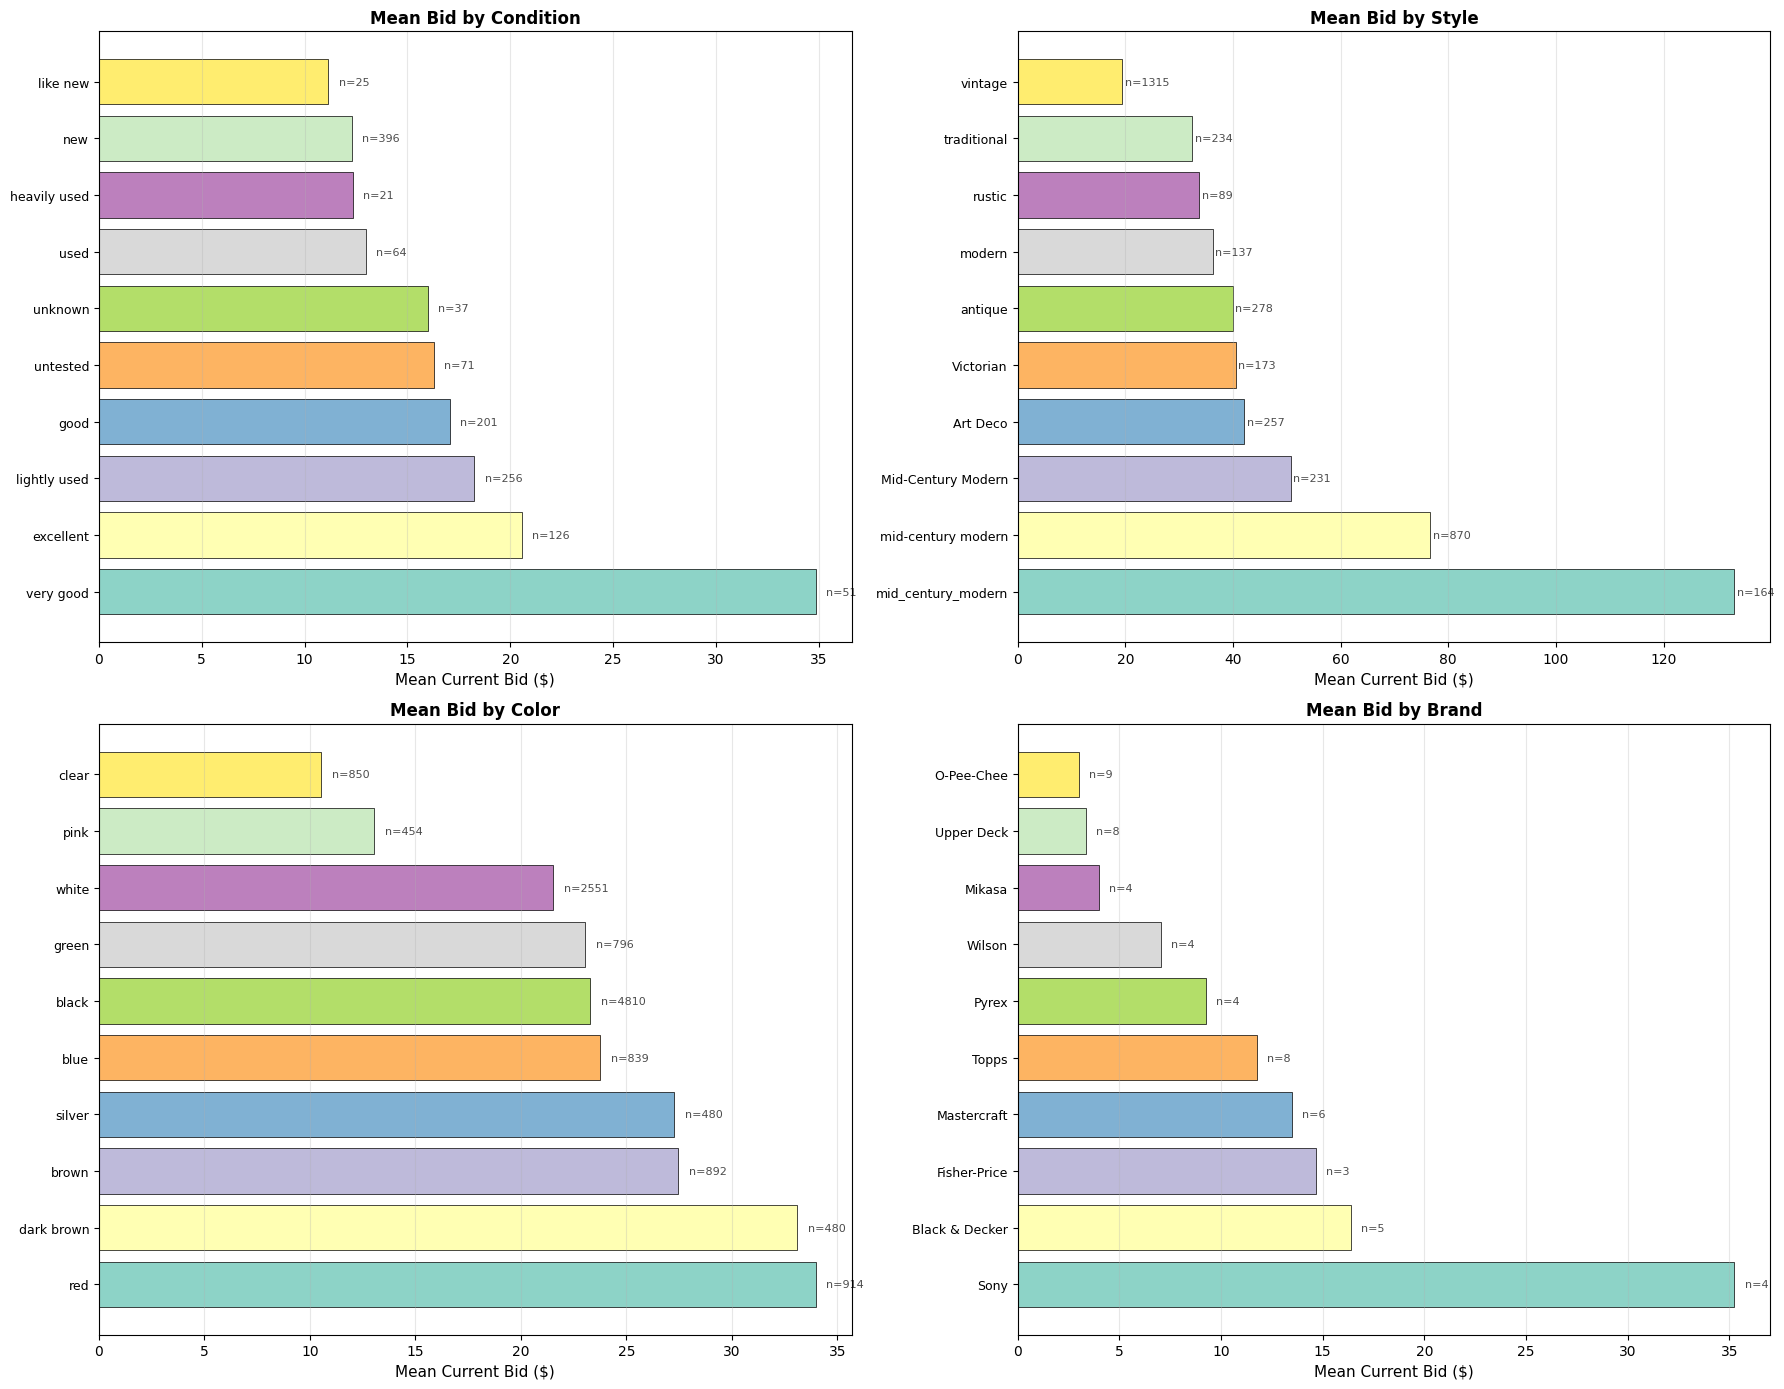

Visualization complete!

CORRELATION ANALYSIS - TOP ATTRIBUTES

Top 15 positive correlations with current_bid:
     attribute              value  correlation  count
        medium      oil on canvas     0.034959    760
         style mid-century modern     0.027625    870
frame_material          gilt wood     0.026450     94
     height_in                 30     0.022509    358
        medium       oil on board     0.021641    443
        medium  acrylic on canvas     0.014620    160
        origin           Ethiopia     0.013860    252
frame_material               wood     0.012535   1779
frame_material              steel     0.010020    106
frame_material           aluminum     0.009643     76
        origin              Italy     0.008536    301
frame_material              metal     0.007954    503
         style           Art Deco     0.004592    257
      width_in                 20     0.004507    228
      width_in                 24     0.004434    344


Top 15 negative correla

In [10]:
# Comprehensive analysis of other attribute relationships with current_bid

# Extract all attribute names and their values
print("Extracting all attributes from items...")
all_attributes = []

for idx, row in merged.iterrows():
    if pd.isna(row["attributes"]):
        continue
    parsed = row["attributes"]
    if isinstance(parsed, str):
        try:
            parsed = json.loads(parsed)
        except Exception:
            try:
                parsed = ast.literal_eval(parsed)
            except Exception:
                continue
    if not isinstance(parsed, list):
        continue
    
    for entry in parsed:
        if not isinstance(entry, dict):
            continue
        name = (entry.get("name") or entry.get("title") or "").lower().strip()
        value = entry.get("value") or entry.get("values") or entry.get("text")
        
        if name and value:
            # Handle list values
            if isinstance(value, list):
                value_str = ", ".join(str(v) for v in value if v)
            else:
                value_str = str(value)
            
            value_str = value_str.strip()
            
            if value_str and len(value_str) < 200:  # Skip very long values
                all_attributes.append({
                    "item_id": row["item_id"],
                    "attr_name": name,
                    "attr_value": value_str,
                    "current_bid": row["current_bid"]
                })

df_all_attrs = pd.DataFrame(all_attributes)
print(f"Total attribute entries: {len(df_all_attrs):,}")
print(f"Unique attribute names: {df_all_attrs['attr_name'].nunique()}")

# Find most common attribute names
print("\n" + "="*80)
print("TOP 20 MOST COMMON ATTRIBUTE NAMES")
print("="*80)
top_attr_names = df_all_attrs['attr_name'].value_counts().head(20)
for attr_name, count in top_attr_names.items():
    print(f"  {attr_name}: {count:,} occurrences")

# Select interesting attributes to analyze in detail (excluding material which we already did)
attributes_to_analyze = [
    "condition", "style", "color", "brand", "size", 
    "type", "finish", "pattern", "shape", "age"
]

# Filter to attributes that actually exist in the data
attributes_to_analyze = [attr for attr in attributes_to_analyze 
                         if attr in df_all_attrs['attr_name'].values]

print(f"\n" + "="*80)
print(f"ANALYZING {len(attributes_to_analyze)} KEY ATTRIBUTES")
print("="*80)
print(f"Attributes: {', '.join(attributes_to_analyze)}")

# Analyze each attribute
attribute_analysis = {}

for attr_name in attributes_to_analyze:
    print(f"\n{'='*80}")
    print(f"ATTRIBUTE: {attr_name.upper()}")
    print("="*80)
    
    attr_data = df_all_attrs[df_all_attrs['attr_name'] == attr_name].copy()
    
    # Get top values for this attribute
    top_values = attr_data['attr_value'].value_counts().head(10)
    
    print(f"\nTop 10 values for '{attr_name}':")
    for value, count in top_values.items():
        print(f"  {value}: {count:,}")
    
    # Calculate bid statistics for each top value
    print(f"\nBid statistics by '{attr_name}':")
    value_stats = []
    
    for value in top_values.index:
        value_items = attr_data[attr_data['attr_value'] == value]
        bids = value_items['current_bid']
        bids_nonzero = bids[bids > 0]
        
        stats = {
            "value": value,
            "count": len(bids),
            "mean_bid": bids.mean(),
            "median_bid": bids.median(),
            "std": bids.std(),
            "zero_pct": 100 * (bids == 0).sum() / len(bids)
        }
        
        if len(bids_nonzero) > 0:
            stats["mean_nonzero"] = bids_nonzero.mean()
            stats["median_nonzero"] = bids_nonzero.median()
        else:
            stats["mean_nonzero"] = 0
            stats["median_nonzero"] = 0
        
        value_stats.append(stats)
        
        print(f"\n  {value}:")
        print(f"    Count: {stats['count']:,}")
        print(f"    Mean bid: ${stats['mean_bid']:.2f}")
        print(f"    Median bid: ${stats['median_bid']:.2f}")
        if stats['mean_nonzero'] > 0:
            print(f"    Mean (non-zero): ${stats['mean_nonzero']:.2f}")
            print(f"    Median (non-zero): ${stats['median_nonzero']:.2f}")
        print(f"    Zero bid rate: {stats['zero_pct']:.1f}%")
    
    attribute_analysis[attr_name] = pd.DataFrame(value_stats)

# Visualize key attributes
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Determine number of attributes to visualize
n_attrs = min(4, len(attributes_to_analyze))
if n_attrs > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for i, attr_name in enumerate(attributes_to_analyze[:n_attrs]):
        ax = axes[i]
        stats_df = attribute_analysis[attr_name].sort_values("mean_bid", ascending=False)
        
        # Bar chart of mean bid by value
        colors = plt.cm.Set3(np.linspace(0, 1, len(stats_df)))
        y_pos = np.arange(len(stats_df))
        ax.barh(y_pos, stats_df["mean_bid"], color=colors, edgecolor='black', linewidth=0.5)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([v[:30] for v in stats_df["value"]], fontsize=9)
        ax.set_xlabel("Mean Current Bid ($)", fontsize=11)
        ax.set_title(f"Mean Bid by {attr_name.title()}", fontsize=12, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add count labels
        for j, (idx, row) in enumerate(stats_df.iterrows()):
            ax.text(row['mean_bid'] + 0.5, j, f"n={row['count']}", 
                   fontsize=8, va='center', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    print("Visualization complete!")

# Correlation analysis for all attributes
print("\n" + "="*80)
print("CORRELATION ANALYSIS - TOP ATTRIBUTES")
print("="*80)

correlation_results = []

for attr_name in top_attr_names.head(15).index:
    if attr_name == "material":  # Skip material as we already did it
        continue
    
    attr_data = df_all_attrs[df_all_attrs['attr_name'] == attr_name]
    
    # For each value, create binary indicator and calculate correlation
    top_values = attr_data['attr_value'].value_counts().head(5)
    
    for value in top_values.index:
        # Create binary indicator in merged dataframe
        indicator_name = f"{attr_name}_{value}"[:50]  # Limit length
        merged[indicator_name] = merged['item_id'].isin(
            attr_data[attr_data['attr_value'] == value]['item_id']
        ).astype(int)
        
        corr = merged[indicator_name].corr(merged['current_bid'])
        
        correlation_results.append({
            "attribute": attr_name,
            "value": value,
            "correlation": corr,
            "count": top_values[value]
        })

corr_results_df = pd.DataFrame(correlation_results).sort_values("correlation", ascending=False)

print("\nTop 15 positive correlations with current_bid:")
print(corr_results_df.head(15).to_string(index=False))

print("\n\nTop 15 negative correlations with current_bid:")
print(corr_results_df.tail(15).to_string(index=False))

# Summary statistics
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Total unique attribute names: {df_all_attrs['attr_name'].nunique()}")
print(f"Total unique attribute values: {df_all_attrs['attr_value'].nunique()}")
print(f"Total attribute-value pairs analyzed: {len(df_all_attrs):,}")
print(f"Items with at least one attribute: {df_all_attrs['item_id'].nunique():,}")
print(f"Average attributes per item: {len(df_all_attrs) / df_all_attrs['item_id'].nunique():.2f}")

In [ ]:
# Analyze attribute PRESENCE (not values) vs current_bid
# Does having an attribute (any value) correlate with higher/lower bids?

print("Analyzing attribute presence vs current_bid...")
print("="*80)

# Extract which attributes each item has (not their values)
item_attributes = {}

for idx, row in merged.iterrows():
    item_id = row["item_id"]
    item_attributes[item_id] = set()
    
    if pd.isna(row["attributes"]):
        continue
    
    parsed = row["attributes"]
    if isinstance(parsed, str):
        try:
            parsed = json.loads(parsed)
        except Exception:
            try:
                parsed = ast.literal_eval(parsed)
            except Exception:
                continue
    
    if not isinstance(parsed, list):
        continue
    
    for entry in parsed:
        if not isinstance(entry, dict):
            continue
        name = (entry.get("name") or entry.get("title") or "").lower().strip()
        if name:
            item_attributes[item_id].add(name)

# Get all unique attribute names
all_attr_names = set()
for attrs in item_attributes.values():
    all_attr_names.update(attrs)

print(f"Total unique attributes found: {len(all_attr_names)}")
print(f"Total items analyzed: {len(item_attributes)}")

# Count frequency of each attribute to get top 25
print("\nIdentifying top 25 most common attributes...")
attr_frequency = {}
for attr_name in all_attr_names:
    count = sum(1 for attrs in item_attributes.values() if attr_name in attrs)
    attr_frequency[attr_name] = count

# Get top 25 most common attributes
top_25_attrs = sorted(attr_frequency.items(), key=lambda x: x[1], reverse=True)[:25]
top_25_attr_names = [name for name, count in top_25_attrs]

print(f"\nTop 25 most common attributes:")
for i, (attr_name, count) in enumerate(top_25_attrs, 1):
    pct = 100 * count / len(item_attributes)
    print(f"{i:2d}. {attr_name:20s} - {count:6,} items ({pct:5.1f}%)")

# Create binary indicators for top 25 attributes only
print(f"\nCreating binary indicators for top 25 attributes...")
attribute_presence = {}

for attr_name in top_25_attr_names:
    merged[f"has_{attr_name}"] = merged["item_id"].apply(
        lambda x: 1 if attr_name in item_attributes.get(x, set()) else 0
    )
    
    # Count how many items have this attribute
    count = merged[f"has_{attr_name}"].sum()
    pct = 100 * count / len(merged)
    attribute_presence[attr_name] = {
        "count": count,
        "percentage": pct
    }

print(f"\n{len(top_25_attr_names)} attributes selected for analysis")

# Calculate correlation and bid statistics for top 25 attributes
print("\n" + "="*80)
print("CORRELATION ANALYSIS - ATTRIBUTE PRESENCE")
print("="*80)

correlation_stats = []

for attr_name in top_25_attr_names:
    has_attr = merged[f"has_{attr_name}"]
    
    # Get count and percentage
    count = has_attr.sum()
    pct = 100 * count / len(merged)
    
    # Debug output
    print(f"Processing '{attr_name}': count={count}, pct={pct:.1f}%")
    
    # Skip if too rare (< 10 items)
    if count < 10:
        print(f"  -> SKIPPED (count < 10)")
        continue
    
    # Calculate correlation
    corr = has_attr.corr(merged["current_bid"])
    
    # Get bid statistics for items with vs without this attribute
    with_attr = merged[merged[f"has_{attr_name}"] == 1]["current_bid"]
    without_attr = merged[merged[f"has_{attr_name}"] == 0]["current_bid"]
    
    with_attr_nonzero = with_attr[with_attr > 0]
    without_attr_nonzero = without_attr[without_attr > 0]
    
    correlation_stats.append({
        "attribute": attr_name,
        "correlation": corr,
        "count_with": len(with_attr),
        "count_without": len(without_attr),
        "mean_with": with_attr.mean(),
        "mean_without": without_attr.mean(),
        "median_with": with_attr.median(),
        "median_without": without_attr.median(),
        "mean_with_nonzero": with_attr_nonzero.mean() if len(with_attr_nonzero) > 0 else 0,
        "mean_without_nonzero": without_attr_nonzero.mean() if len(without_attr_nonzero) > 0 else 0,
        "percentage": pct
    })

print(f"\nTotal attributes added to correlation_stats: {len(correlation_stats)}")

if len(correlation_stats) == 0:
    print("ERROR: No attributes passed the filtering criteria!")
    print("This means all top 25 attributes have < 10 items, which shouldn't happen.")
    print("Check if binary indicators were created correctly.")
    # Create visualizations
else:
        corr_df = pd.DataFrame(correlation_stats).sort_values("correlation", ascending=False)corr_df = pd.DataFrame(correlation_stats).sort_values("correlation", ascending=False)

    # Show top positive correlations
    print("\nTop 20 attributes with POSITIVE correlation (presence = higher bids):")
    print("="*80)
    for idx, row in corr_df.head(20).iterrows():
        print(f"\n{row['attribute']}:")
        print(f"  Correlation: {row['correlation']:.4f}")
        print(f"  Items with attribute: {row['count_with']:,} ({row['percentage']:.1f}%)")
        print(f"  Items without: {row['count_without']:,}")
        print(f"  Mean bid WITH: ${row['mean_with']:.2f} | WITHOUT: ${row['mean_without']:.2f}")
        print(f"  Median bid WITH: ${row['median_with']:.2f} | WITHOUT: ${row['median_without']:.2f}")
        if row['mean_with_nonzero'] > 0:
            print(f"  Mean (non-zero) WITH: ${row['mean_with_nonzero']:.2f} | WITHOUT: ${row['mean_without_nonzero']:.2f}")

    # Show top negative correlations
    print("\n" + "="*80)
    print("Top 20 attributes with NEGATIVE correlation (presence = lower bids):")
    print("="*80)
    for idx, row in corr_df.tail(20).iterrows():
        print(f"\n{row['attribute']}:")
        print(f"  Correlation: {row['correlation']:.4f}")
        print(f"  Items with attribute: {row['count_with']:,} ({row['percentage']:.1f}%)")
        print(f"  Items without: {row['count_without']:,}")
        print(f"  Mean bid WITH: ${row['mean_with']:.2f} | WITHOUT: ${row['mean_without']:.2f}")
        print(f"  Median bid WITH: ${row['median_with']:.2f} | WITHOUT: ${row['median_without']:.2f}")
        if row['mean_with_nonzero'] > 0:
            print(f"  Mean (non-zero) WITH: ${row['mean_with_nonzero']:.2f} | WITHOUT: ${row['mean_without_nonzero']:.2f}")

    # Create visualizations
    print("\n" + "="*80)
    print("CREATING VISUALIZATIONS")
    print("="*80)

    fig = plt.figure(figsize=(18, 16))
    gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3)

    # 1. Correlation bar chart (top positive)
    ax1 = fig.add_subplot(gs[0, 0])
    top_positive = corr_df.head(15)
    colors_pos = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_positive)))
    y_pos = np.arange(len(top_positive))
    ax1.barh(y_pos, top_positive["correlation"], color=colors_pos, edgecolor='black', linewidth=0.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_positive["attribute"], fontsize=9)
    ax1.set_xlabel("Correlation with Current Bid", fontsize=11)
    ax1.set_title("Top 15 Positive Correlations\n(Attribute Presence → Higher Bids)", 
                  fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # 2. Correlation bar chart (top negative)
    ax2 = fig.add_subplot(gs[0, 1])
    top_negative = corr_df.tail(15).sort_values("correlation")
    colors_neg = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_negative)))
    y_pos = np.arange(len(top_negative))
    ax2.barh(y_pos, top_negative["correlation"], color=colors_neg, edgecolor='black', linewidth=0.5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(top_negative["attribute"], fontsize=9)
    ax2.set_xlabel("Correlation with Current Bid", fontsize=11)
    ax2.set_title("Top 15 Negative Correlations\n(Attribute Presence → Lower Bids)", 
                  fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # 3. Mean bid comparison (top positive correlations)
    ax3 = fig.add_subplot(gs[1, 0])
    top_10_pos = corr_df.head(10)
    x = np.arange(len(top_10_pos))
    width = 0.35
    ax3.bar(x - width/2, top_10_pos["mean_with"], width, label='With Attribute', color='green', alpha=0.7)
    ax3.bar(x + width/2, top_10_pos["mean_without"], width, label='Without Attribute', color='gray', alpha=0.7)
    ax3.set_xticks(x)
    ax3.set_xticklabels(top_10_pos["attribute"], rotation=45, ha='right', fontsize=9)
    ax3.set_ylabel("Mean Current Bid ($)", fontsize=11)
    ax3.set_title("Mean Bid: With vs Without Attribute\n(Top 10 Positive Correlations)", 
                  fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(axis='y', alpha=0.3)

    # 4. Mean bid comparison (top negative correlations)
    ax4 = fig.add_subplot(gs[1, 1])
    top_10_neg = corr_df.tail(10).sort_values("correlation")
    x = np.arange(len(top_10_neg))
    ax4.bar(x - width/2, top_10_neg["mean_with"], width, label='With Attribute', color='red', alpha=0.7)
    ax4.bar(x + width/2, top_10_neg["mean_without"], width, label='Without Attribute', color='gray', alpha=0.7)
    ax4.set_xticks(x)
    ax4.set_xticklabels(top_10_neg["attribute"], rotation=45, ha='right', fontsize=9)
    ax4.set_ylabel("Mean Current Bid ($)", fontsize=11)
    ax4.set_title("Mean Bid: With vs Without Attribute\n(Top 10 Negative Correlations)", 
                  fontsize=12, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(axis='y', alpha=0.3)

    # 5. Scatter: correlation vs attribute frequency
    ax5 = fig.add_subplot(gs[2, :])
    scatter_colors = ['green' if c > 0 else 'red' for c in corr_df["correlation"]]
    ax5.scatter(corr_df["percentage"], corr_df["correlation"], 
               c=scatter_colors, alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
    ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax5.set_xlabel("Attribute Frequency (% of items)", fontsize=11)
    ax5.set_ylabel("Correlation with Current Bid", fontsize=11)
    ax5.set_title("Attribute Frequency vs Correlation with Bid Amount", 
                  fontsize=12, fontweight='bold')
    ax5.grid(alpha=0.3)

    # Add labels for most extreme correlations
    for idx, row in corr_df.head(5).iterrows():
        ax5.annotate(row["attribute"][:15], 
                    (row["percentage"], row["correlation"]), 
                    fontsize=8, alpha=0.8, xytext=(5, 5),
                    textcoords='offset points')
    for idx, row in corr_df.tail(5).iterrows():
        ax5.annotate(row["attribute"][:15], 
                    (row["percentage"], row["correlation"]), 
                    fontsize=8, alpha=0.8, xytext=(5, -5),
                    textcoords='offset points')

    # 6. Distribution of correlations
    ax6 = fig.add_subplot(gs[3, :])
    ax6.hist(corr_df["correlation"], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax6.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Correlation')
    ax6.axvline(x=corr_df["correlation"].mean(), color='green', linestyle='--', linewidth=2, 
               label=f'Mean = {corr_df["correlation"].mean():.4f}')
    ax6.set_xlabel("Correlation Coefficient", fontsize=11)
    ax6.set_ylabel("Number of Attributes", fontsize=11)
    ax6.set_title("Distribution of Correlations (Attribute Presence vs Current Bid)", 
                  fontsize=12, fontweight='bold')
    ax6.legend(fontsize=10)
    ax6.grid(axis='y', alpha=0.3)

    plt.suptitle("Attribute Presence vs Current Bid Analysis", 
                 fontsize=15, fontweight='bold', y=0.995)
    plt.show()

    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(f"Total attributes analyzed: {len(corr_df)}")
    print(f"Positive correlations: {(corr_df['correlation'] > 0).sum()} ({100*(corr_df['correlation'] > 0).sum()/len(corr_df):.1f}%)")
    print(f"Negative correlations: {(corr_df['correlation'] < 0).sum()} ({100*(corr_df['correlation'] < 0).sum()/len(corr_df):.1f}%)")
    print(f"Mean correlation: {corr_df['correlation'].mean():.4f}")
    print(f"Median correlation: {corr_df['correlation'].median():.4f}")
    print(f"Strongest positive: {corr_df.iloc[0]['attribute']} ({corr_df.iloc[0]['correlation']:.4f})")
    print(f"Strongest negative: {corr_df.iloc[-1]['attribute']} ({corr_df.iloc[-1]['correlation']:.4f})")

    print("\nVisualization complete!")

IndentationError: unindent does not match any outer indentation level (<string>, line 136)